# Notebook for loading MAR netcdfs
Loads yearly netcdfs of daily 2D and 3D variables.

Also saves the runoff variable as a zarr to 'gs://ldeo-glaciology/MAR/20km/zarr-test/test.zarr'

In [1]:
import xarray as xr
import os
import fsspec
import gcsfs

Initializing cluster

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39363")
client

<Client: 'tcp://127.0.0.1:39363' processes=10 threads=10, memory=40.00 GiB>

## 1. Load the whole dataset from the netcdfs

In [3]:
# Setup the file names
fs = gcsfs.GCSFileSystem(project='pangeo-integration-te-3eea', mode='ab', cache_timeout = 0)
gcsdir = 'gs://ldeo-glaciology/'
marsdir = 'MAR'
res = '20km'
filepattern = 'MARv3.12-20km-daily-ERA5*'
pattern = os.path.join(gcsdir, marsdir, res, filepattern)
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} MAR files.\n")
NCs

Total of 21 MAR files.



['ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2000.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2001.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2002.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2003.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2004.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2005.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2006.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2007.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2008.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2009.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2010.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2011.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2012.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2013.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2014.nc',
 'ldeo-glaciology/MAR/20km/MARv3.12-20km-daily-ERA5-2015.nc',
 'ldeo-g

Try loading one netcdf

In [4]:
NCs_urls = ['gs://' + x + '#mode=bytes' for x in NCs]
openfile = fs.open(NCs_urls[0], mode='rb') 
ds1 = xr.open_dataset(openfile)

this one netcdf should be one year of data, so check the length of the TIME dimension.  2000 was a leap year so this should be 366 :+1:

In [5]:
len(ds1.TIME)  

366

Now load all the files

In [6]:
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs] # needed for open_mfdataset
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', 
                       concat_dim='TIME')

Check that the concatenation along the TIME dimension has worked ok. 

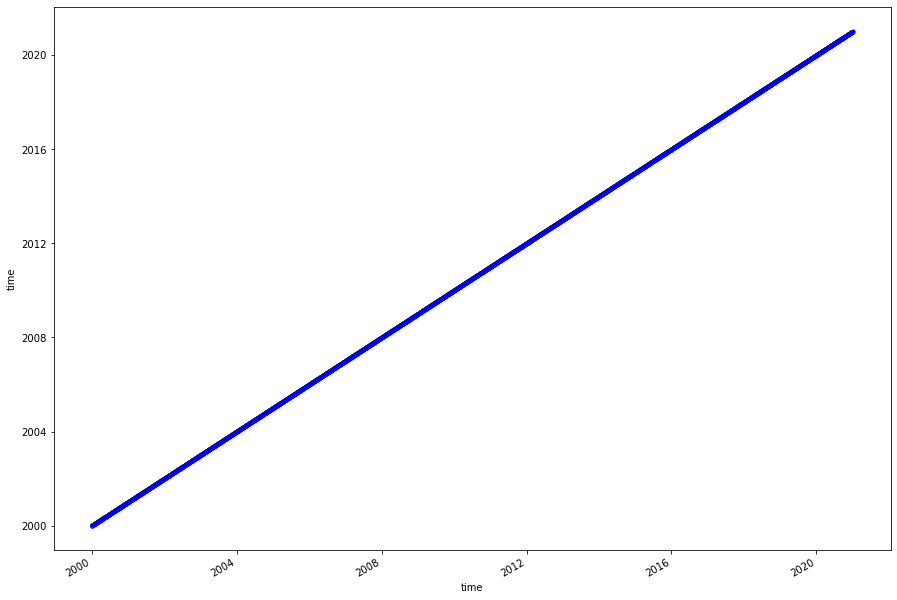

In [7]:
ds.TIME.plot.line("b.",size=10)

## 2. Make simple plot to make sure the data are there

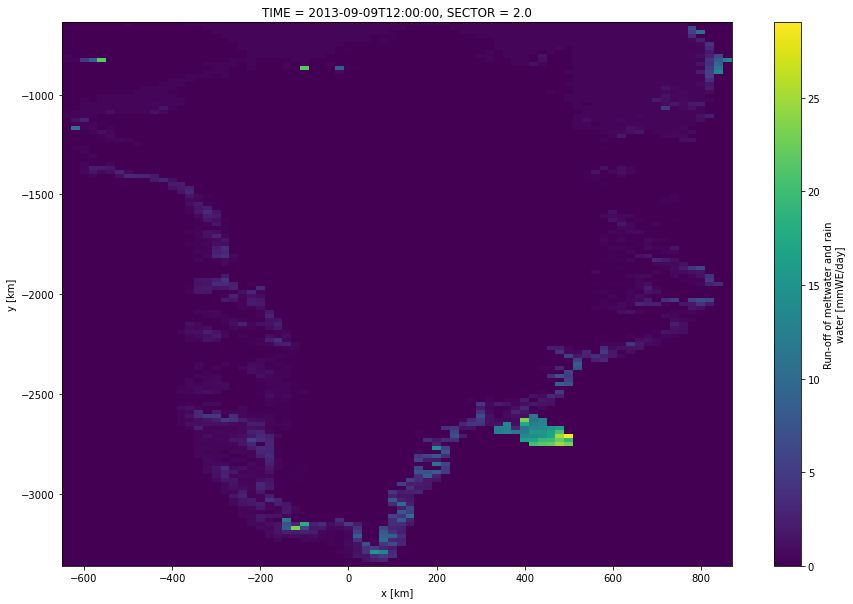

In [8]:
ds.RU[5000,1].plot(size=10)

In [9]:
RU = ds.RU
print(f"Whole dataset is {ds.nbytes/1e9} GB.\n")
print(f"Just the runoff variable is {RU.nbytes/1e9} GB.\n")

Whole dataset is 35.522507227 GB.

Just the runoff variable is 0.634299648 GB.



## 3. Try to compute a mean. 

In [10]:
RUmean = RU.mean()

In [11]:
RUmean

<xarray.DataArray 'RU' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Computation of the mean in the cell below is very slow and I have not waited long enough for it to complete yet. Also, even when the cluster is running (by clicking on the + sign in the menu on the left) it doesnt seem to use the cluster for the comutation. 

George: So to add on the cluster (or at least what I think is the cluster, you need to click on the "< >" button next to scale after creating a new cluster. I did so, and it added it at the start

In [12]:
RUmean.compute()

<xarray.DataArray 'RU' ()>
array(1.3723419, dtype=float32)

## 4. Save the runoff variable as a zarr in the google bucket

In [39]:
# define the directory for the zarr
import json
outdir = os.path.join(gcsdir, marsdir, res, 'zarr-test/')
outdir

'gs://ldeo-glaciology/MAR/20km/zarr-test/'

In [40]:
# set up the mapper with the token for writing
with open('../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

mar_mapper = fsspec.get_mapper(outdir + 'test.zarr', mode='ab',
                            token=token)

In [44]:
# convert to a dataset (.to_zarr requires this).
RU_ds = RU.to_dataset()

CPU times: user 262 µs, sys: 0 ns, total: 262 µs
Wall time: 268 µs


.to_zarr complained that the chunks were not uniform (it requires all chunks to be the same size except the final one and apparently RU_ds did not meet hti srequirement)
So rechunk to remove chunks in the time dimension

In [51]:
RU_ds = RU_ds.chunk({"TIME": -1})

The .to_zarr call. works. It is very slow though. 

In [52]:
RU_ds.to_zarr(mar_mapper, mode='w');

Reload the runoff dataset and compare to original to make sure it is the same.

In [56]:
RU_reloaded = xr.open_zarr(fs.get_mapper('gs://ldeo-glaciology/MAR/20km/zarr-test/test.zarr'))  
RU_reloaded.identical(RU_ds)